https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/01-introduction-to-pytorch.html

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data

from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
from tqdm.notebook import tqdm

set_matplotlib_formats("svg", "pdf")

/home/martin/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  del sys.path[0]


In [12]:
print("Using torch", torch.__version__) # chequear la version
torch.manual_seed(42) # setting seed 

Using torch 1.8.1+cu102


In [15]:
x = torch.Tensor(2,3,4)
x

tensor([[[0.0000e+00, 1.3733e-43, 2.6302e+20, 6.1949e-04],
         [6.4805e-10, 6.3008e-10, 4.1485e-08, 6.8358e-04],
         [1.7342e-07, 2.6511e-09, 6.4097e-10, 1.4580e-19]],

        [[1.1495e+24, 3.0956e-18, 2.3592e-09, 3.3857e-06],
         [1.6691e+22, 1.6986e-07, 5.4174e-05, 1.0514e-05],
         [6.7059e+22, 2.7151e-06, 2.4016e-18, 2.0552e+32]]])

In [41]:
x = torch.arange(0,12)
x

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [45]:
y = x.view(3,4)
y

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [70]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)  # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


In [71]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

Y tensor(12.6667, grad_fn=<MeanBackward0>)


In [72]:
y.backward()

In [78]:
x.grad

tensor([1.3333, 2.0000, 2.6667])

In [79]:
gpu_avail = torch.cuda.is_available()

# Definiendo dispositivo

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [3]:
x = torch.zeros(3,3).to(device)
print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


# Redes Neuronales - nn.Module

Note that parameters are only registered for nn.Module objects that are direct object attributes, i.e. self.a = .... If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like nn.ModuleList, nn.ModuleDict and nn.Sequential, that allow you to have different data structures of modules

In [4]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        # inits para el modulo
        
    def forward(self, x):
        # funcion para calcular el procesamiento del modulo
        pass

In [5]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [6]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [8]:
# para ver los parametros de la red
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [14]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data ponts we want to generate
            std  - Standar deviation of the noise
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor() #esto se ejecuta en el cosntructor!
        
    def generate_continuous_xor(self):
        #entra self pq le voy a dar atributos desde aca
        data  = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1)==1).to(torch.long) #lo transforma para sumar ruidito
        data += self.std * torch.randn(data.shape)
        self.data = data
        self.label = label
       
    
    def __len__(self):
        return self.size
    
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label


In [170]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([ 1.0864, -0.1109]), tensor(1))


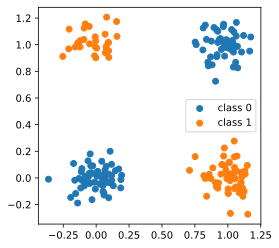

In [171]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data =  data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], label='class 0')
    plt.scatter(data_1[:,0], data_1[:,1], label='class 1')
    plt.legend()
visualize_samples(dataset.data, dataset.label)

In [174]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)
data_inputs, data_labels = next(iter(data_loader))

print('Data inputs', data_inputs.shape, '\n', data_inputs)
print('Data labels', data_labels.shape, '\n', data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.0501,  0.9828],
        [ 0.8181,  0.0172],
        [ 0.9923,  0.0293],
        [ 1.1126, -0.0764],
        [ 0.9882,  1.0379],
        [ 1.0489,  0.2768],
        [ 1.0430,  0.9446],
        [ 0.9757,  0.9142]])
Data labels torch.Size([8]) 
 tensor([0, 1, 1, 1, 0, 1, 0, 0])


In [175]:
loss_module = nn.BCEWithLogitsLoss()

In [176]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [222]:
train_dataset = XORDataset(size=1000, std=0.5)
train_data_loader = data.DataLoader(train_dataset, batch_size = 128, shuffle=True)

In [223]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [224]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train() # set to train mode
    
    # training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            # 1 : Mando los datos al device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            # 2 : Corro el modelo sobre los datos
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # de [batch, 1] a [batch]
            
            # 3 : Calculo la loss
            loss = loss_module(preds, data_labels.float())
            
            # 4 : Backpropago
            #     me aseguro el pre cero
            optimizer.zero_grad()
            #     aplico backprop
            loss.backward()
            
            # 5 : Actualizar los parametros del modelo
            optimizer.step()

train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [225]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 2.0303, -1.0196],
        [-0.1157,  1.7660],
        [-1.3798, -2.9904],
        [ 2.0977,  0.8669]], device='cuda:0')), ('linear1.bias', tensor([ 1.1062,  0.1865, -0.1010,  0.4927], device='cuda:0')), ('linear2.weight', tensor([[-2.5842, -3.0636, -2.1430,  1.7855]], device='cuda:0')), ('linear2.bias', tensor([0.5174], device='cuda:0'))])


In [226]:
torch.save(state_dict,"our_model.tar")

In [227]:
# Verifico si guarde bien, cargando y formando un nuevo modelo
state_dict = torch.load("our_model.tar")

new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[ 2.0303, -1.0196],
        [-0.1157,  1.7660],
        [-1.3798, -2.9904],
        [ 2.0977,  0.8669]], device='cuda:0')), ('linear1.bias', tensor([ 1.1062,  0.1865, -0.1010,  0.4927], device='cuda:0')), ('linear2.weight', tensor([[-2.5842, -3.0636, -2.1430,  1.7855]], device='cuda:0')), ('linear2.bias', tensor([0.5174], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 2.0303, -1.0196],
        [-0.1157,  1.7660],
        [-1.3798, -2.9904],
        [ 2.0977,  0.8669]])), ('linear1.bias', tensor([ 1.1062,  0.1865, -0.1010,  0.4927])), ('linear2.weight', tensor([[-2.5842, -3.0636, -2.1430,  1.7855]])), ('linear2.bias', tensor([0.5174]))])


In [228]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [229]:
def eval_model(model, data_loader):
    model.eval()  # Set model to eval mode
    true_preds, num_preds = 0.0, 0.0

    with torch.no_grad():  # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)  # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long()  # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
eval_model(model, test_data_loader)

Accuracy of the model: 99.80%


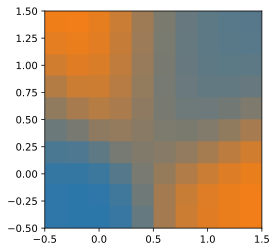

In [233]:
@torch.no_grad()  # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    #plt.figure(figsize=(4, 4))
    #plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    #plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    #plt.title("Dataset samples")
    #plt.ylabel(r"$x_2$")
    #plt.xlabel(r"$x_1$")
    #plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.2, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.2, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    # Specifying "None" in a dimension creates a new one
    output_image = (1 - preds) * c0[None, None] + preds * c1[None, None]
    output_image = (
        output_image.cpu().numpy()
    )  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin="lower", extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)


visualize_classification(model, dataset.data, dataset.label)
plt.show()